<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sprintの目的**

・スクラッチを通してSVMを理解する

・線形モデルと異なる手法に触れる

**どのように学ぶか**

スクラッチでSVMを実装した後、学習と検証を行なっていきます。

# 2.SVMスクラッチ

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。

In [21]:
# 雛形

class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    """
    # 閾値を1e-5としている根拠はVectorの指示による
    def __init__(self, num_iter = 100, lr = 0.01, kernel='linear', gamma = 1, d =1, theta =0, threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.d = d
        self.theta = theta
        self.threshold = threshold
        self.verbose = verbose

    def _kernel(self, X1, X2):
        """
        カーネル関数を作成する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        if self.kernel == 'poly':
          self.gamma = 1
          self.theta = 1
          self.d = 2
        
        return (self.gamma * np.dot(X1, X2.T) + self.theta)**self.d
    
    def _lambda_update(self, X, y):
      for i in range(len(X)):
        total = 0
        for j in range(len(X)):
          total += self.lam[j] * y[i] * y[j] * self._kernel(X[i], X[j])
        
        self.lam[i] += self.lr * (1 - total)

        if self.lam[i] < 0:
          self.lam[i] = 0

    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # λの初期値を設定
        self.lam = np.random.rand(len(X))

        # yのユニーク値
        self.ylabel = np.unique(y)
        # yのラベルを-1, 1に置き換える
        y = np.where(y == self.ylabel[0], -1, 1)

        for i in range(self.iter):
          self._lambda_update(X, y)

          # 学習プロセスの出力 (verboseをTrueにした際は学習過程を出力)
          if self.verbose:
            print('iter_n:', i, 'lambda:', self.lam)

          # サポートベクターの抽出・仕様
          self.index_support_vectors = np.where(self.lam > self.threshold)
          self.X_sv = X[self.lam > self.threshold]
          self.n_support_vectors = len(self.X_sv)
          self.lam_sv = self.lam[self.lam > self.threshold]
          self.y_sv = y[self.lam > self.threshold]

    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        y_pred = np.zeros(len(X))

        for i in range(len(X)):
          total = 0
          for j in range(self.n_support_vectors):
            total += self.lam_sv[j] * self.y_sv[j] * self._kernel(X[i], self.X_sv[j])
          
          if total >= 0:
            y_pred[i] = self.ylabel[1]
          else:
            y_pred[i] = self.ylabel[0]
        
        return y_pred


**【問題1】ラグランジュの未定乗数法による最急降下**

SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$
ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。


\[k(x_i, x_j) = x_{i}^{T} x_j\]
条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。


$i, j$ : サンプルのインデックス


$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数


$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数


$\alpha$ : 学習率


$\lambda_j$ : j番目のサンプルのラグランジュ乗数


$y_i$ : i番目のサンプルのラベル


$y_j$ : j番目のサンプルのラベル


$x_i$ : i番目のサンプルの特徴量ベクトル


$x_j$ : j番目のサンプルの特徴量ベクトル


あるサンプルに対してのすべてのサンプルとの関係を計算していくことになります。



In [2]:
# 必要なライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(seed = 1234)

n_samples = 100
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0, 0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples / 2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples / 2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples / 2))),
                    np.ones((int(n_samples / 2))) * (-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
sample1_X = X[random_index]
sample1_y = y[random_index]

In [4]:
# 少量のサンプルによるテスト
X = sample1_X = X[20 : 40]
y = sample1_y = y[20 : 40]
print(X)
print(y)

[[-0.89316335  1.74858479]
 [-0.37812172  1.30954722]
 [-0.95137044  1.48121779]
 [-0.87600858  2.13555852]
 [-1.78472253  1.35142527]
 [-1.34064571  0.74494371]
 [ 0.36194177  3.2981155 ]
 [-0.43415884  2.47437575]
 [-1.32462297  1.65291662]
 [-2.02548671  1.95207375]
 [-0.05351326  2.90199673]
 [-1.22623181  1.64190199]
 [-1.2216594   0.26016042]
 [-2.565068   -0.28773148]
 [-1.42386246  2.021842  ]
 [-0.40098685  2.89124539]
 [-1.83363731  1.4974582 ]
 [-0.75621369  3.51365769]
 [-0.85081276  1.42018161]
 [-1.61204335  1.41294666]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
# 0〜1までの乱数を生成させる
lam = np.random.rand(len(X))
lam.reshape(-1, 1)

array([[0.76445129],
       [0.22728855],
       [0.38749154],
       [0.49016629],
       [0.52521129],
       [0.51334927],
       [0.75777343],
       [0.35511886],
       [0.51460648],
       [0.33840972],
       [0.85725545],
       [0.57467626],
       [0.4114045 ],
       [0.32613068],
       [0.60433544],
       [0.47201608],
       [0.98286988],
       [0.92706395],
       [0.34516176],
       [0.37327842]])

In [6]:
# イテレーション
num_iter = 100

for _ in range(num_iter):
  for i in range(len(X)):
    total = 0
    for j in range(len(X)):
      total += lam[j] * y[i] * y[j] * np.dot(X[i], X[j])
    
    lam += 0.01 * (1 - total)

    if lam[i] < 0:
      lam[i] = 0

print('lambda:\n', lam.reshape(-1, 1))

lambda:
 [[-0.00030623]
 [-0.00357603]
 [-0.002287  ]
 [ 0.00119998]
 [ 0.0002773 ]
 [-0.00344594]
 [ 0.00369116]
 [ 0.00183936]
 [ 0.00055059]
 [ 0.00321487]
 [ 0.00253773]
 [ 0.00042083]
 [-0.00567808]
 [-0.00820956]
 [ 0.00233951]
 [ 0.00319179]
 [ 0.11757643]
 [ 0.0617705 ]
 [ 0.0002232 ]
 [ 0.        ]]


In [ ]:
# numpyを用いる
xx = np.array([[1, 2],
               [1, 2],
               [2, 4],
               [2, 4]])

np.dot(xx[1],xx.T)

array([ 5,  5, 10, 10])

In [ ]:
a = np.dot(X[0], X.T)
print(a)

[3.85528954 2.62757881 3.43976411 4.51662391 3.95713043 2.50001285
 5.44376148 4.71443057 4.07336955 5.22245696 5.12218344 3.96623016
 1.54605395 1.78790183 4.80710393 5.41373447 4.25617027 6.81935075
 3.24322274 3.91047508]


In [ ]:
b = lam * y[0] * y
print(b)

[-0.00030623 -0.00357603 -0.002287    0.00119998  0.0002773  -0.00344594
  0.00369116  0.00183936  0.00055059  0.00321487  0.00253773  0.00042083
 -0.00567808 -0.00820956  0.00233951  0.00319179  0.11757643  0.0617705
  0.0002232   0.        ]


In [ ]:
a * b

array([-0.00118059, -0.00939629, -0.00786674,  0.00541984,  0.00109732,
       -0.00861489,  0.0200938 ,  0.00867153,  0.00224277,  0.01678954,
        0.01299874,  0.00166911, -0.00877862, -0.01467789,  0.01124627,
        0.01727949,  0.50042532,  0.42123471,  0.00072389,  0.        ])

In [ ]:
np.sum(a * b)

0.9693773124060548

In [ ]:
np.dot(a, b)

0.969377312406055

In [ ]:
c = np.dot(X, X.T)
print(c.shape)

(20, 20)


In [ ]:
d = lam * y * y.T
print(d.shape)

(20,)


In [ ]:
np.dot(c, d)

array([0.96937731, 0.65631515, 0.8678214 , 1.13243875, 1.01141478,
       0.64301978, 1.33805875, 1.17294377, 1.03142263, 1.32857808,
       1.26647571, 1.00309074, 0.40508676, 0.49026716, 1.21457421,
       1.34508258, 1.08622011, 1.69907198, 0.81736126, 0.99661952])

**【問題2】サポートベクターの決定**

計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

In [7]:
# λが閾値よりも大きいサンプルの抽出
threshold = 1e-5 # Diverの指定に従って閾値を設定
sup_vec = X[lam > threshold]
print(sup_vec)

[[-0.87600858  2.13555852]
 [-1.78472253  1.35142527]
 [ 0.36194177  3.2981155 ]
 [-0.43415884  2.47437575]
 [-1.32462297  1.65291662]
 [-2.02548671  1.95207375]
 [-0.05351326  2.90199673]
 [-1.22623181  1.64190199]
 [-1.42386246  2.021842  ]
 [-0.40098685  2.89124539]
 [-1.83363731  1.4974582 ]
 [-0.75621369  3.51365769]
 [-0.85081276  1.42018161]]


In [8]:
# インデックスの取得
sup_index = np.where(lam > threshold)
print(sup_index)

(array([ 3,  4,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18]),)


In [9]:
# サポートベクターのλ値とラベル値を取得する
sup_lam = lam[lam > 0]
sup_y = y[lam > 0]
print(sup_lam)
print(sup_y)

[0.00119998 0.0002773  0.00369116 0.00183936 0.00055059 0.00321487
 0.00253773 0.00042083 0.00233951 0.00319179 0.11757643 0.0617705
 0.0002232 ]
[1 1 1 1 1 1 1 1 1 1 1 1 1]


**【問題3】推定**

推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(x)$ の符号が分類結果です。

$$
f(x) = \sum_{n=1}^{N}\lambda_n y_{sv_n} k(x, s_n)
$$

$x$ : 推定したいデータの特徴量ベクトル


$N$ : サポートベクターの数


$n$ : サポートベクターのインデックス


$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数


$y_{sv_n}$ : $n$番目のサポートベクターのラベル


$k()$ : カーネル関数


$s_n$ : $n$番目のサポートベクターの特徴量

In [10]:
X_test = X[0 : 5]
X_test

array([[-0.89316335,  1.74858479],
       [-0.37812172,  1.30954722],
       [-0.95137044,  1.48121779],
       [-0.87600858,  2.13555852],
       [-1.78472253,  1.35142527]])

In [11]:
for i in range(len(X_test)):
  total = 0
  for j in range(len(sup_vec)):
    total += sup_lam[j] * sup_y[j] * np.dot(X_test[i], sup_vec[j])
  
  if total > 0:
    print('f(X):{:.1f}, class:{}'.format(total, 1))
  else:
    print('f(X):{:.1f}, class{}'.format(total, -1))

f(X):1.0, class:1
f(X):0.7, class:1
f(X):0.9, class:1
f(X):1.2, class:1
f(X):1.1, class:1


# 3.検証

**【問題4】学習と推定**

機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。




In [12]:
# 機械学習スクラッチ入門のSprintで用意したシンプルデータセット1を用いて学習と推定を行う
np.random.seed(seed = 0)

n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0, 0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples / 2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples / 2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))),
                    np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
sample1_X = X[random_index]
sample1_y =y[random_index]

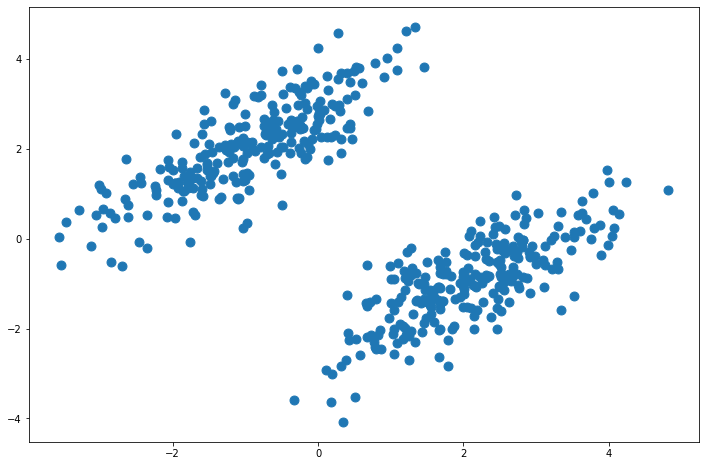

In [13]:
# シンプルデータセット可視化
flg = plt.subplots(figsize = (12, 8))
plt.rcParams['font.size'] = 10
plt.scatter(sample1_X[:, 0], sample1_X[:, 1], s = 80)

In [14]:
# 訓練データとテストデータを分けるライブラリ
from sklearn.model_selection import train_test_split
X = sample1_X
y = sample1_y
# 訓練データとテストデータに分ける
X_train1, X_valid1, y_train1, y_valid1 = \
train_test_split(X, y, train_size=0.7, random_state=0)

print('X_train.shape : ',X_train1.shape)
print('y_train.shape : ',y_train1.shape)
print('X_valid.shape : ',X_valid1.shape)
print('y_valid.shape : ',y_valid1.shape)

X_train.shape :  (350, 2)
y_train.shape :  (350,)
X_valid.shape :  (150, 2)
y_valid.shape :  (150,)


In [15]:
# Xを確認する
print(X)

[[ 7.72382751e-01 -2.29167329e+00]
 [-5.93349449e-01  1.66788336e+00]
 [-2.07648560e+00  4.87468451e-01]
 [ 1.19226877e-01  3.62537974e+00]
 [-3.13000578e+00 -1.56731551e-01]
 [-1.78109832e+00  1.22224904e+00]
 [ 3.99770982e+00  1.25164011e+00]
 [ 2.15604470e+00 -3.85824429e-01]
 [ 1.94741552e+00 -1.29638961e+00]
 [ 1.58757396e+00 -1.85989193e+00]
 [ 2.05369045e+00 -9.47185530e-01]
 [-1.97439392e+00  1.22718715e+00]
 [-3.47487306e+00  3.70421433e-01]
 [ 1.68094977e+00 -6.36507554e-01]
 [-9.51997101e-01  1.41989638e+00]
 [-1.23054341e+00  2.48848983e+00]
 [-6.96789478e-01  1.88359001e+00]
 [ 1.03842491e+00 -8.88815671e-01]
 [ 3.68706491e+00  4.30242556e-01]
 [-1.03002856e+00  1.27865865e+00]
 [-1.26658152e+00  1.97258945e+00]
 [-1.97638843e-02  2.54412654e+00]
 [ 8.60592217e-01 -2.46186096e+00]
 [ 1.18894987e+00 -8.80504418e-01]
 [-1.87575023e+00  1.56364771e+00]
 [ 2.46165485e+00 -2.00601784e+00]
 [-1.59848154e+00  1.10652913e+00]
 [ 3.98744618e+00 -1.36849117e-01]
 [-9.99508672e-01  2

In [16]:
# yを確認する
y

array([-1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,
        1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,
       -1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1, -1,  1,  1

In [22]:
# スクラッチ実装による学習と推定
SSC = ScratchSVMClassifier(num_iter = 100, lr = 0.01)

SSC.fit(X_train1, y_train1)
y_pred1 = SSC.predict(X_valid1)

In [23]:
Show = False

if Show:
  print('予測 : ', y_pred1)
  print('検証 : ', y_valid1)

In [25]:
# スコア算出
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('正解率:{}'.format(accuracy_score(y_valid1, y_pred1)))
print('適合率:{}'.format(precision_score(y_valid1, y_pred1)))
print('再現率:{}'.format(recall_score(y_valid1, y_pred1)))
print('F値:{}'.format(f1_score(y_valid1, y_pred1)))
print(confusion_matrix(y_valid1, y_pred1))

正解率:1.0
適合率:1.0
再現率:1.0
F値:1.0
[[65  0]
 [ 0 85]]


In [26]:
# scikit-learnによる実装と比べ、正しく動いているかを確認
# 必要なライブラリの読み込み
from sklearn.svm import SVC
# クラスの初期化
model = SVC()
# 学習
model.fit(X_train1, y_train1)

y_pred2 = model.predict(X_valid1)

In [27]:
print('正解率:{}'.format(accuracy_score(y_valid1, y_pred2)))
print('適合率:{}'.format(precision_score(y_valid1, y_pred2)))
print('再現率:{}'.format(recall_score(y_valid1, y_pred2)))
print('F値:{}'.format(f1_score(y_valid1, y_pred2)))
print(confusion_matrix(y_valid1, y_pred2))

正解率:1.0
適合率:1.0
再現率:1.0
F値:1.0
[[65  0]
 [ 0 85]]


〈問題4解答〉
以上のとおり、スクラッチ実装した結果は、scikit-learnによる実装と比べ、正しく動いていることを確認できた。

**【問題5】決定領域の可視化**

決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

# 4.SVMとはどのような仕組みか

スクラッチ実装に必要な情報は以上ですが、大まかな仕組みの解説を行います。


SVMは決定境界と近くの点の距離（マージン）を最大化する方法です。特徴量が2つであれば以下の図のように線を引くことを考えます。

決定境界は線形であれば、線形回帰やロジスティック回帰と同様に次の式です。

$$
y(x) = w^{T}x
$$

$x$ : 特徴量ベクトル


$w$ : 重みベクトル


決定境界とある点 $x$ との距離 $r$ は以下の式で求められます。高校数学で学ぶ「点と直線の距離の公式」や「点と平面の距離の公式」を一般化したものです。

$$
r = \frac{y_{i}y(x)}{||w||} = \frac{y_{i}w^{T}x}{||w||}
$$

$||w||$ はベクトル $w$ の大きさで、特徴量が2つならば $||w|| = \sqrt{w_{1}^2+w_{2}^2}$ です。また、学習するi番目のデータのラベルを $y_{i}=-1$または$y_{i}=1$ としています。


訓練データの中で「最も距離 $r$ が短くなる点x（サポートベクター）の距離 $r$ を最大化する $w$ を求める」ことがSVMによる分類だと言い換えられます。


これは非常に複雑な問題です。 $w$ を変化させると、最も距離 $r$ が短くなる点x（サポートベクター）も変化していくからです。計算するためには、問題を扱いやすい形に変形させる必要があります。



**扱いやすい形にする**

まず定数 $M(>0)$ を置くと、先ほどの問題は、


「$\frac{M}{||w||}$ を $y_{i}(w^{T}x_{i})\geq M$ という条件の元で最大化する $w$ や $M$ を求める問題」


と表現できます。条件式は $x_{i}$ に訓練データのすべての点を入れて成り立つ必要があります。まだまだややこしいですが、これをMで割ってしまいます。そうすると、


「$\frac{1}{||w||}$ を $y_{i}(\frac{w^{T}}{M}x_{i})\geq 1$ という条件の元で最大化する $w$ や $M$ を求める問題」


になり、さらに $w^{T} \gets \frac{w^{T}}{M}$ と置き換えてしまいます。


そうすれば、


「 $\frac{1}{||w||}$ を $y_{i}(w^{T}X_{i})\geq 1$ という条件の元で最大化する $w$を求める問題」


まで簡単化できます。 $\frac{1}{||w||}$ を最大化するというのは $||w||$ を最小化することと同じです。これを後々さらに扱いやすくするために $\frac{1}{2}||w||^2$ を最小化すると考えます。よって、


「 $\frac{1}{2}||w||^2$ を $y_{i}(w^{T}x_{i})\geq 1$ という条件の元で最小化する $w$ を求める問題」


とすることができます。

**解きやすい問題にする（双対化）**

こういった不等式制約を持つ最適化問題は次のように ラグランジュの未定乗数法 で置き換えられることが知られています。


なお、このように難しい問題を別の簡単な問題に言い換えることを 双対化する といいます。


ラグランジュの未定乗数法を用いると以下のラグランジュ関数が得られます。

$$
L(w,\lambda) = \frac{1}{2}||w||^2 - \sum_{i=1}^{N}\lambda_{i}\{y_{i}(w^{T}x_{i})-1\}
$$

$\lambda$ はラグランジュ乗数と呼ばれる数で、0以上の値です。これを $w$について微分し、0に等しいと置くと、次の式が得られます。

$$
w = \sum_{i=1}^{N}\lambda_{i}y_{i}x_{i}
$$
（この微分のために $||w||$ ではなく $\frac{1}{2}||w||^2$ としています）


これをラグランジュ関数に代入して整理すると

$$
\sum_{i=1}^{N}\lambda_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}ｙ_{i}ｙ_{j}x_{i}^Tx_{j}
$$
を $\lambda_{i} \geq 0$ かつ $\sum_{n=1}^{N}\lambda_{i}y_{i} = 0$ の条件の元で最大化するときの $\lambda_{i}$ を探す問題に双対化できます。


この形になれば、$\lambda$ を勾配降下法により求めることができます。$w$は出てきませんが、得られる結果は同じです。

**カーネル**

最後の式の $x_{i}^{T} x_j$ の部分を $k(x_i, x_j)$ という関数に置き換えます。この関数を カーネル関数 と呼びます。

$$
\sum_{i=1}^{N}\lambda_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}ｙ_{i}ｙ_{j}k(x_i, x_j)
$$
この式が問題1の最急降下法の式の元になります。


カーネル関数は $x_{i}^{T} x_j$ ではないさまざまな計算に置き換えることができます。この部分を置き換えるだけで、元の特徴量を **高次元空間** に移動させたことと同じ結果が得られ、高い分類性能を得ることができます。これを **カーネルトリック** と呼びます。



**高次元へ移す簡単な例**

次の図のように1次元上に2色の点があるとします。これらを直線一本を引くことで分けることは不可能です。
https://t.gyazo.com/teams/diveintocode/e75b3c8d2692afa9fba4f76485a883eb.png

しかし、例えば以下のように変換してみると直線でも分けられそうです。
$x^2=2.5$ あたりに線を引くことになります。
https://t.gyazo.com/teams/diveintocode/5f5bacd8aac5831f1936759362b8a184.png

これは$x^2$を計算し、それを縦軸にプロットしたグラフです。1次元だったデータを $\phi(x)=x^2$ の関数により高次元（2次元）へと移動しました。

こういったことをSVMはカーネルトリックにより行います。

In [36]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step = 0.01, title = 'decision region', xlabel = 'xlabel', ylabel = 'ylabel', target_names = ['versicolor', 'virginica']):
  scatter_color = ['red', 'blue']
  countourf_color = ['pink', 'skyblue']
  n_class = 2

  # 予測
  mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:, 0]) - 0.5,
                                           np.max(X[:, 0]) + 0.5, step),
                                 np.arange(np.min(X[:, 1]) - 0.5,
                                           np.max(X[:, 1]) + 0.5, step))
  
  mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
  y_pred = model.predict(mesh).reshape(mesh_f0.shape)

  # 描画
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.contourf(mesh_f0, mesh_f1, y_pred, n_class -1, cmap = ListedColormap(countourf_color))
  plt.contour(mesh_f0, mesh_f1, y_pred, n_class -1, colors = 'y', linewidths = 5, alpha = 0.5)

  for i, target in enumerate(set(y)):
    plt.scatter(X[y == target][:, 0],
                X[y == target][:, 1],
                s = 80,
                color = scatter_color[i],
                label = target_names[i], marker = 'o')

    patches = [mpatches.Patch(color = scatter_color[i], label = target_names[i]) for i in range(n_class)]
    plt.scatter(model.X_sv[:,0],model.X_sv[:,1], color = 'yellow', s = 80, label = 'Support Vector')
    plt.legend(handles=patches)
    plt.legend()

Number of Support_Vector 8


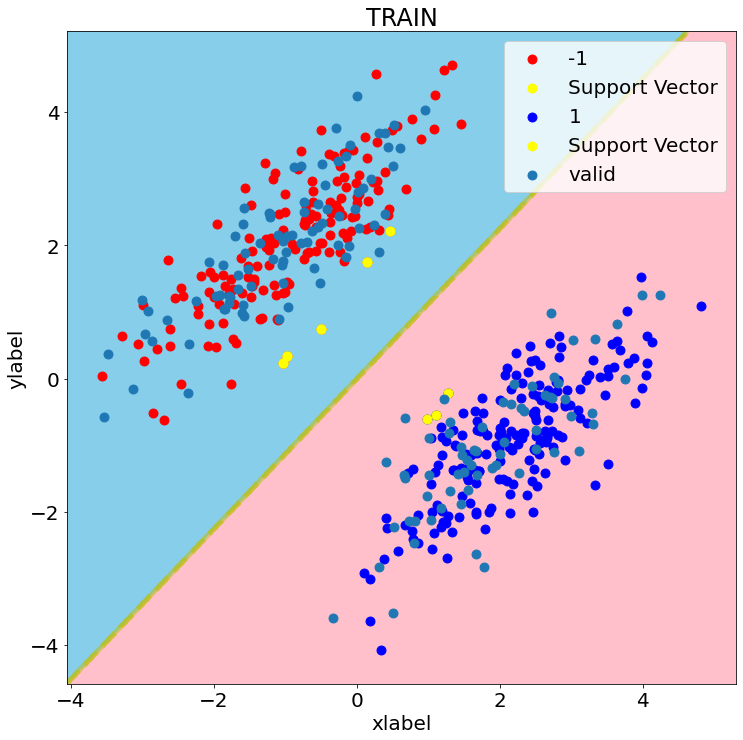

In [38]:
fit, ax = plt.subplots(figsize = (12, 12))
plt.rcParams['font.size'] = 20
print('Number of Support_Vector', SSC.n_support_vectors)
decision_region(X_train1, y_train1, SSC, title = 'TRAIN', target_names = ['-1', '1'])
plt.scatter(X_valid1[:, 0], X_valid1[:, 1], s = 80, label = 'valid')
plt.legend()

# 5.他のカーネル関数の実装

**【問題6】（アドバンス課題）多項式カーネル関数の作成**

最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

「多項式カーネルの式」

$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$

$\gamma$, $\theta_0$, $d$ はハイパーパラメータです。


線形カーネルは $\gamma = 1$, $\theta_0 = 0$, $d = 1$の場合の多項式カーネルと等しいと言えます。